In [1]:
#Packages
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
import tensorflow.keras.losses
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import os
import math
import cmath
import datetime
from my_classes import DataGenerator,STMImage,DataGeneratorAug, DataGeneratorMultiInputAug, DataGeneratorPeakMask
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage import filters
from tqdm import notebook
from scipy.spatial import cKDTree
import scipy.optimize
from scipy.fft import fft, ifft, fft2, ifft2, rfft2, irfft2

# Predicting a dataset and error histograms

In [2]:
#Loads in the proper model
model_name='run9_8'
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))
model=models.load_model(os.path.join('Models',model_name),compile=False)
model.compile(optimizer='Adam', loss=root_mean_squared_error, metrics=['mse','mae'])

In [5]:
#Sets the directory for the training set and the eventual prediction file
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project\\Training_set_9_7_centerpoint'
#os.makedirs(os.path.join("Training_Set_Predictions",model_name))
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))

batch_size=200
array_dim=(32,32,1)

#Creates a generator that feeds images with no labels into the predict method
predict_IDs=dft['filename'].values


#Creates a dictionary that maps the filenames to their labels. Also can make dictionaries for any extra inputs, such as bond length
#label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
label_names=['x_coord','y_coord']
ID_list=dft['filename'].values
label_list=dft[label_names].values
#extra_inputs_list=dft['bl'].values
labels={}
#extra_inputs={}
i=0
for ID in ID_list:
    labels[ID]=label_list[i]
    #extra_inputs[ID]=extra_inputs_list[i]
    i+=1
    

#Creates the generator. MultiInputAug is for additional float inputs,
#     PeakMask is for inputting a mask alongside the image, and DataGeneratorAug is for just inputing the image
#prediction_generator=DataGeneratorMultiInputAug(predict_IDs,labels,extra_inputs,shuffle=False,directory=test_dataset_dir,batch_size=batch_size,train=False,norm='divmax')

prediction_generator=DataGeneratorAug(predict_IDs,labels,shuffle=False,directory=test_dataset_dir,batch_size=batch_size,dim=array_dim,train=False,norm='divmax')

#prediction_generator=DataGeneratorPeakMask(predict_IDs,labels,shuffle=False,directory=test_dataset_dir,batch_size=batch_size,dim=array_dim,train=False,norm='divmax')


In [6]:
#Generates predictons for all images in the training directory. Saves these predictions to a pandas dataframe
os.makedirs(os.path.join("Training_Set_Predictions",model_name))



##Predicting 8 labeled models
# im_names=predict_IDs
# central_atom_x_labels=[]
# central_atom_y_labels=[]
# neighbor_vect_1_x_labels=[]
# neighbor_vect_1_y_labels=[]
# neighbor_vect_2_x_labels=[]
# neighbor_vect_2_y_labels=[]
# neighbor_vect_3_x_labels=[]
# neighbor_vect_3_y_labels=[]

# prediction=model.predict(prediction_generator,verbose=1)

# for p in prediction:
#     central_atom_x_labels.append(p[0])
#     central_atom_y_labels.append(p[1])
#     neighbor_vect_1_x_labels.append(p[2])
#     neighbor_vect_1_y_labels.append(p[3])
#     neighbor_vect_2_x_labels.append(p[4])
#     neighbor_vect_2_y_labels.append(p[5])
#     neighbor_vect_3_x_labels.append(p[6])
#     neighbor_vect_3_y_labels.append(p[7])

# data={
#     'filename':im_names,'x_coord':central_atom_x_labels,'y_coord':central_atom_y_labels, 
#     'neighbor1x':neighbor_vect_1_x_labels, 'neighbor1y':neighbor_vect_1_y_labels,
#     'neighbor2x':neighbor_vect_2_x_labels, 'neighbor2y':neighbor_vect_2_y_labels,
#     'neighbor3x':neighbor_vect_3_x_labels, 'neighbor3y':neighbor_vect_3_y_labels,
#     }
# df=pd.DataFrame(data)
# df.to_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"),index=False)


#Predicting 2 labeled models
im_names=predict_IDs
center_uc_x_labels=[]
center_uc_y_labels=[]


prediction=model.predict(prediction_generator,verbose=1)

for p in prediction:
    center_uc_x_labels.append(p[0])
    center_uc_y_labels.append(p[1])


data={
    'filename':im_names,'x_coord':center_uc_x_labels,'y_coord':center_uc_y_labels
    }
df=pd.DataFrame(data)
df.to_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"),index=False)

2000/2000 [==============================] - 267s 134ms/step


<function matplotlib.pyplot.show(*args, **kw)>

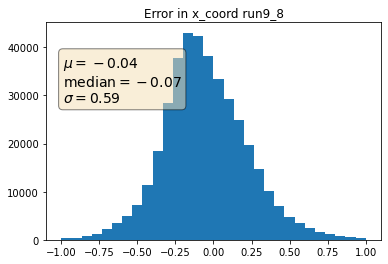

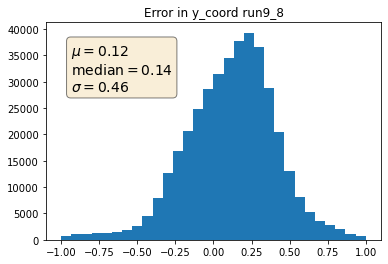

<Figure size 432x288 with 0 Axes>

In [11]:
#Calculates the error between the predictions and labels for a given model on a dataset. Plots histograms of the error and saves the results
model_name='run9_8'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project\\Training_set_9_7_centerpoint'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))


arr_len=dfp.shape[0]
def get_error(column):
    diff= (dft[column].to_numpy()[:arr_len]-dfp[column].to_numpy())*32
    return diff

def get_metrics(data):
    return data.mean(), np.median(data), data.std()

#os.makedirs(os.path.join('Prediction_Plots',model_name))
plot_dir=os.path.join('Prediction_Plots',model_name)


def plot_error(error,name,_range=(-1,1),save_fig=True):
    mu, median, sigma =get_metrics(error)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))
    plt.text(.05, 0.85, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)
    plt.hist(error,bins=30,range=_range)
    plt.title('Error in ' + name +" "+ model_name)
    if save_fig:
        plt.savefig(os.path.join(plot_dir,model_name+" error_"+name+".png"))
    plt.figure()
    
    
error_x=get_error('x_coord')
error_y=get_error('y_coord')
# error_neighbor1x=get_error('neighbor1x')
# error_neighbor1y=get_error('neighbor1y')
# error_neighbor2x=get_error('neighbor2x')
# error_neighbor2y=get_error('neighbor2y')
# error_neighbor3x=get_error('neighbor3x')
# error_neighbor3y=get_error('neighbor3y')


props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
fig = plt.figure()
ax = plt.subplot(1,1,1)

save_fig=True
plot_error(error_x,'x_coord',save_fig=save_fig)
plot_error(error_y,'y_coord',save_fig=save_fig)
# plot_error(error_neighbor1x,'neighbor1x',save_fig=save_fig)
# plot_error(error_neighbor1y,'neighbor1y',save_fig=save_fig)
# plot_error(error_neighbor2x,'neighbor2x',save_fig=save_fig)
# plot_error(error_neighbor2y,'neighbor2y',save_fig=save_fig)
# plot_error(error_neighbor3x,'neighbor3x',save_fig=save_fig)
# plot_error(error_neighbor3y,'neighbor3y',save_fig=save_fig)


plt.show

<function matplotlib.pyplot.show(*args, **kw)>

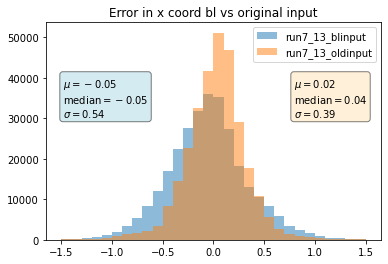

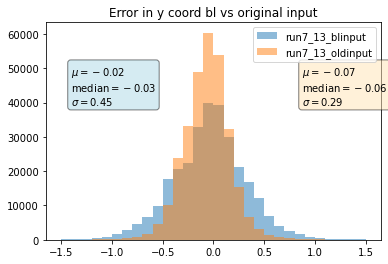

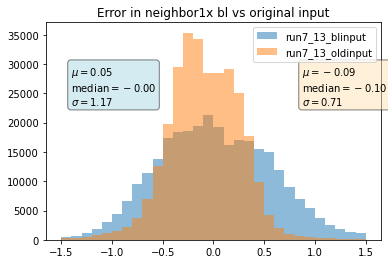

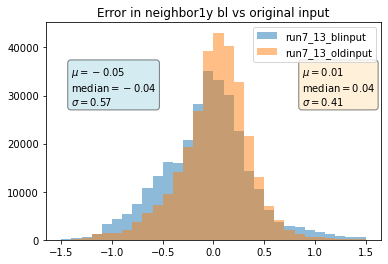

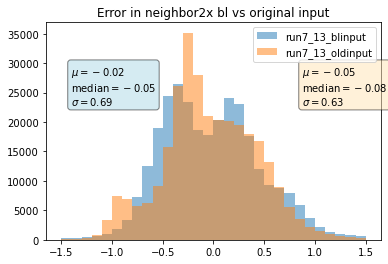

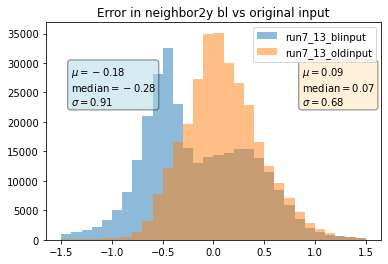

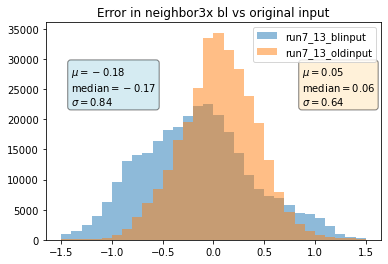

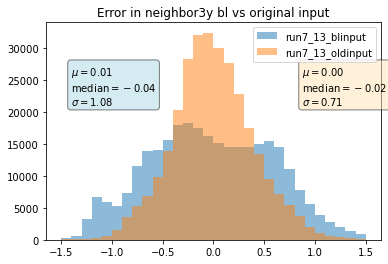

<Figure size 432x288 with 0 Axes>

In [71]:
#Code for comparing two models. Calculates the error between the predictions and labels for a given model on a dataset. Plots histograms of the error and saves the results
graph_name='bl vs original input'
model_name='run7_13_blinput'
model_name_2='run7_13_oldinput'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_7_13'
test_dataset_dir_2 ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_7_13'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
prediction_dir_2=os.path.join("Training_Set_Predictions",model_name_2)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dft_2 = pd.read_csv(os.path.join(test_dataset_dir_2,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))
dfp_2= pd.read_csv(os.path.join(prediction_dir_2,"predictions_dataframe.csv"))

def get_error(column):
    diff= (dft[column].to_numpy()-dfp[column].to_numpy())*32
    return diff

def get_error_2(column):
    diff= (dft_2[column].to_numpy()-dfp_2[column].to_numpy())*32
    return diff

def get_metrics(data):
    return data.mean(), np.median(data), data.std()

def plot_dual_error(data1,data2,name,range=(-1.5,1.5)):
    mu, median, sigma =get_metrics(data1)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))

    plt.text(.05, 0.75, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props)
    mu, median, sigma =get_metrics(data2)
    textstr = '\n'.join((
        r'$\mu=%.2f$' % (mu, ),
        r'$\mathrm{median}=%.2f$' % (median, ),
        r'$\sigma=%.2f$' % (sigma, )))
    plt.text(.74, 0.75, textstr, transform=ax.transAxes, fontsize=10,
            verticalalignment='top', bbox=props_2)
    plt.hist(data1,bins=30,range=range,alpha=.5,label=model_name)
    plt.hist(data2,bins=30,range=range,alpha=.5,label=model_name_2)
    plt.legend(loc="upper right")
    plt.title('Error in ' +name+" "+ graph_name)
    plt.savefig(os.path.join(plot_dir,"Error in "+name+" new seed.png"))
    plt.figure()

#os.makedirs(os.path.join('Prediction_Plots',graph_name))
plot_dir=os.path.join('Prediction_Plots',graph_name)

error_x=get_error('x_coord')
error_y=get_error('y_coord')
error_neighbor1x=get_error('neighbor1x')
error_neighbor1y=get_error('neighbor1y')
error_neighbor2x=get_error('neighbor2x')
error_neighbor2y=get_error('neighbor2y')
error_neighbor3x=get_error('neighbor3x')
error_neighbor3y=get_error('neighbor3y')


error_x_2=get_error_2('x_coord')
error_y_2=get_error_2('y_coord')
error_neighbor1x_2=get_error_2('neighbor1x')
error_neighbor1y_2=get_error_2('neighbor1y')
error_neighbor2x_2=get_error_2('neighbor2x')
error_neighbor2y_2=get_error_2('neighbor2y')
error_neighbor3x_2=get_error_2('neighbor3x')
error_neighbor3y_2=get_error_2('neighbor3y')


props = dict(boxstyle='round', facecolor='lightblue', alpha=0.5)
props_2 = dict(boxstyle='round', facecolor='moccasin', alpha=0.5)
fig = plt.figure()
ax = plt.subplot(1,1,1)

plot_dual_error(error_x,error_x_2,"x coord")
plot_dual_error(error_y,error_y_2,"y coord")
plot_dual_error(error_neighbor1x,error_neighbor1x_2,"neighbor1x")
plot_dual_error(error_neighbor1y,error_neighbor1y_2,"neighbor1y")
plot_dual_error(error_neighbor2x,error_neighbor2x_2,"neighbor2x")
plot_dual_error(error_neighbor2y,error_neighbor2y_2,"neighbor2y")
plot_dual_error(error_neighbor3x,error_neighbor3x_2,"neighbor3x")
plot_dual_error(error_neighbor3y,error_neighbor3y_2,"neighbor3y")


plt.show

# Real STM Data Preprocessing

In [14]:
#Planar fit
stm=np.loadtxt('MoC2 _ 886.txt')
stm=stm[150:500,150:500]
#stm*=-1
x=[]
y=[]
z=[]
for i in range(stm.shape[0]):
    for j in range(stm.shape[1]):
        x.append(i)
        y.append(j)
        z.append(stm[i,j])
XYZ=np.array([x,y,z])
# Inital guess of the plane, equation Ax+By+Cz=D, [A,B,C,D]
p0 = [0.506645455682, -0.185724560275, -1.43998120646, 1.37626378129]

#p0 = [-8.0e-08, -4.0e-08 ,-7.0e+04, 5.0e-02]
#[-8.72248736e-08 -4.21458081e-08 -7.08683096e+04  5.61787973e-02]

#Solution:  [-9.17834972e-06 -4.43484631e-06 -7.45720935e+06  5.91148646e+00]
#Old Error:  4.0303793611249143e-10
#New Error:  5.92582717977428e-17
def f_min(X,p):
    plane_xyz = p[0:3]
    distance = (plane_xyz*X.T).sum(axis=1) + p[3]
    return distance / np.linalg.norm(plane_xyz)

def residuals(params, signal, X):
    return f_min(X, params)

from scipy.optimize import leastsq
sol = leastsq(residuals, p0, args=(None, XYZ))[0]

print("Solution: ", sol)
print("Old Error: ", (f_min(XYZ, p0)**2).sum())
print("New Error: ", (f_min(XYZ, sol)**2).sum())

plane=np.fromfunction(lambda x,y: (x*sol[0]+y*sol[1]-sol[3])/sol[2],stm.shape,dtype=float)
stm=stm+plane

Solution:  [ 4.90206418e-08  3.58727293e-08 -2.76487246e+04 -4.17664767e-03]
Old Error:  324524224.9305786
New Error:  1.7762791248787421e-15


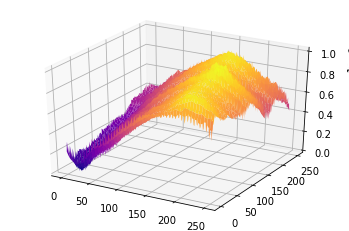

Fitted parameters:
[ 1.37913562e-02 -1.40814438e+00  1.26538315e+00  3.82651134e-10
  4.06857628e-03]
RMS residual = 4.1887872580279604e-11


NameError: name 'plot_3d' is not defined

In [13]:
#Sin wave fit part 1
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


stm=np.loadtxt('strained_graphene.txt')
stm=stm[0:250,0:250]
# The two-dimensional domain of the fit.
ny,nx = stm.shape
x = np.linspace(0,nx,nx)
y = np.linspace(0,ny,ny)
X, Y = np.meshgrid(x,y)
# Our function to fit is going to be a sum of two-dimensional Gaussians
def sin_line(x, y, w, phi, d, A, m):
    return A *( np.sin(w*x+phi+m*y) +d )

# A list of the sin_line parameter guesses: w, phi, d, A, m

# The function to be fit is Z.
Z=stm

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
#ax.set_zlim(0,np.max(Z)+2)
plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _sin_line(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    arr += sin_line(x, y, *args)
    return arr

# Initial guesses to the fit parameters: w, phi, d, A, m
guess_prms = ((2*np.pi)/350, -np.pi/2, 0.3, 1e-9, np.pi/600)

# Flatten the initial guess parameter list.
p0 = guess_prms

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_sin_line, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)
fit += sin_line(X, Y, *popt)
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, fit, cmap='plasma')
# cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
# ax.set_zlim(-4,np.max(fit))
# plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
# fig = plt.figure()
# ax = fig.add_subplot(111)
# ax.imshow(Z, origin='bottom', cmap='plasma',
#           extent=(x.min(), x.max(), y.min(), y.max()))
# ax.contour(X, Y, fit, colors='w')
# plt.show()


plot_3d(Z-fit)
stm2=Z-fit

<IPython.core.display.Javascript object>


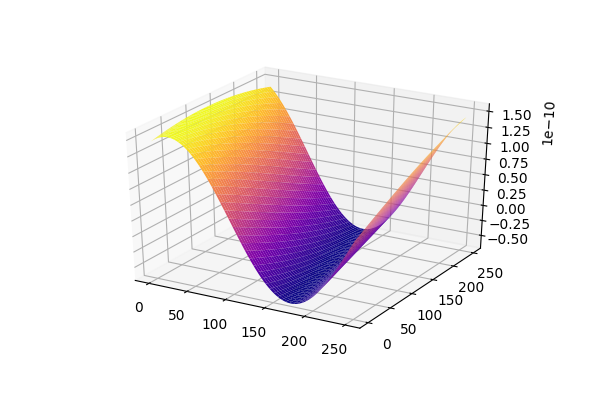

<IPython.core.display.Javascript object>


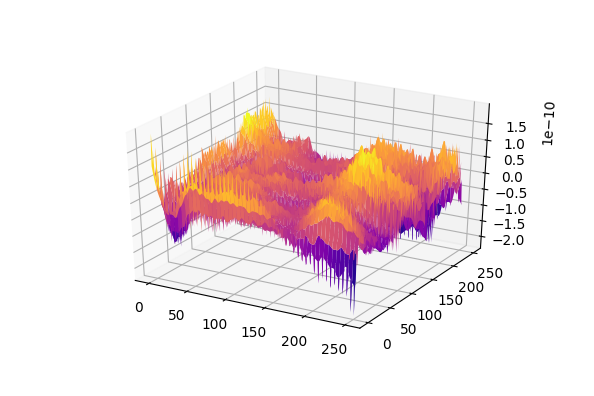

Fitted parameters:
[ 7.43774230e-02 -7.41640074e+00 -1.05548559e-02  8.76575750e-12
  1.34702429e-02  2.38633283e-11  4.85735132e-02 -2.49387528e+00]
RMS residual = 3.78250893790442e-11


<IPython.core.display.Javascript object>


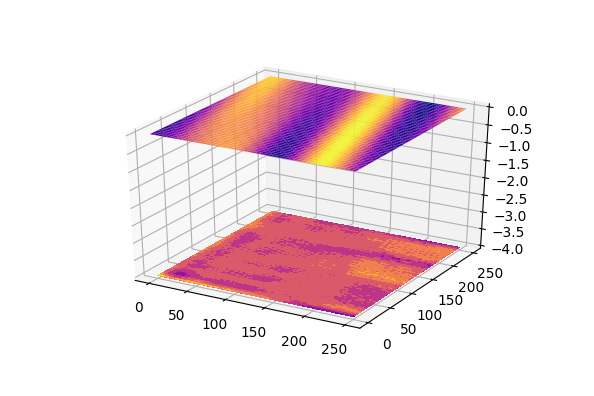

<IPython.core.display.Javascript object>


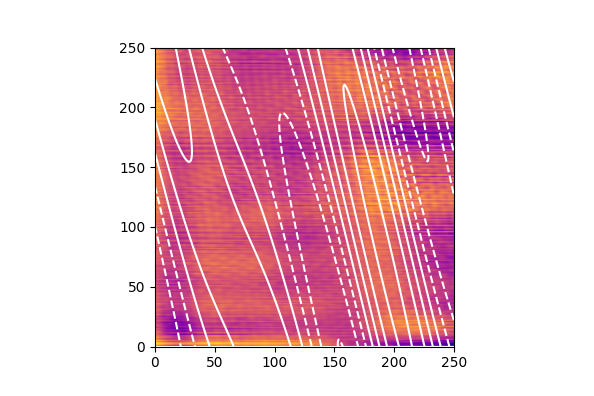

<IPython.core.display.Javascript object>


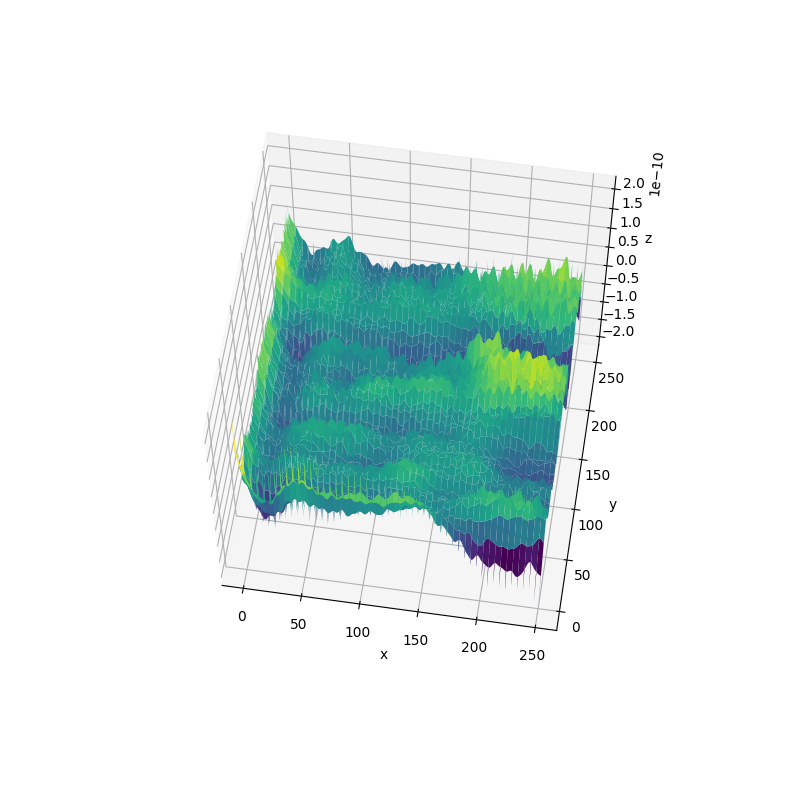

In [14]:
#Sin wave fit part 2
ny,nx = stm2.shape
x = np.linspace(0,nx,nx)
y = np.linspace(0,ny,ny)
X, Y = np.meshgrid(x,y)
# Our function to fit is going to be a sum of two-dimensional Gaussians
def sin_line_2(x, y, w, phi, d, A, m,A2,w2,phi2):
    return A *( np.sin(w*x+phi+m*y) +d )+A2 *( np.sin(w2*x+phi2+m*y) +d )

# The function to be fit is Z.
# A list of the sin_line parameter guesses: w, phi, d, A, m, A2,w2,phi2
guess=((2*np.pi)/300, 0, 0.3, 5e-11, 4.06857628e-03,1e-10,2*np.pi/300,np.pi/2)

Z=stm2
Test = np.zeros(X.shape)
Test += sin_line_2(X, Y, *guess)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Test, cmap='plasma')
plt.show()


fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap='plasma')
plt.show()

# fig = plt.figure()
# ax = fig.gca(projection='3d')
# ax.plot_surface(X, Y, Z-Test, cmap='plasma')
# plt.show()

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled
# to one dimension.
def _sin_line_2(M, *args):
    x, y = M
    arr = np.zeros(x.shape)
    arr += sin_line_2(x, y, *args)
    return arr

# Initial guesses to the fit parameters.
guess_prms = [guess]

# Flatten the initial guess parameter list.
#p0 = [p for prms in guess_prms for p in prms]
p0=guess
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
popt, pcov = curve_fit(_sin_line_2, xdata, Z.ravel(), p0)
fit = np.zeros(Z.shape)

fit += sin_line_2(X, Y, *popt)
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)


#Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, fit, cmap='plasma')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='plasma')
ax.set_zlim(-4,np.max(fit))
plt.show()

#Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, origin='bottom', cmap='plasma',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='w')
plt.show()


plot_3d(Z-fit)
stm3=Z-fit

## Applying a 2D Fourier Transform and mask cutouts

D:\anaconda3\envs\PythonGPU\lib\site-packages\ipykernel_launcher.py:86: RuntimeWarning: divide by zero encountered in log


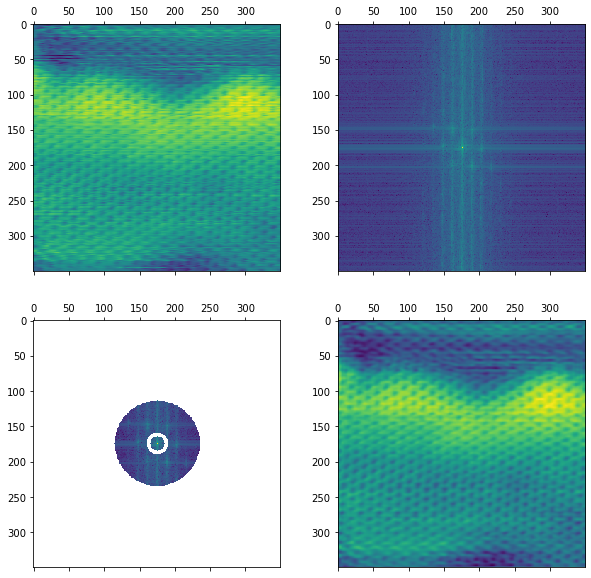

In [15]:
#%matplotlib inline
#stm=stm2
#stm=np.loadtxt('MoC2 _ 886.txt')
#Studying fourier transform of stm
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask
def create_donut_mask(h, w, center=None, inner_radius=None, outer_radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if outer_radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])
    if inner_radius is None:
        inner_radius=0

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask1 = dist_from_center >= outer_radius 
    mask2= dist_from_center <= inner_radius
    mask = mask1 | mask2
    return mask
def square_mask_delete(mask):
    fshift[crow-mask:crow+mask, ccol-mask:ccol+mask] = 0
def square_mask_keep(arr,mask):
    arr[0:crow-mask] = 0
    arr[crow+mask:] = 0
    arr[crow-mask:crow+mask, 0:ccol-mask] = 0
    arr[crow-mask:crow+mask, ccol+mask:] = 0 
def cutoff(cutoff):
    for x in range(fshift.shape[0]):
        for y in range(fshift.shape[1]):
            if abs(fshift[x,y])<=cutoff:
                fshift[x,y]=0+0j

fsize=10
fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(2,2,1)
ax.matshow(stm,cmap='viridis')


f=np.fft.fft2(stm)
fshift=np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))
#fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(2,2,2)
#ax = plt.subplot(1,1,1)
ax.matshow(magnitude_spectrum,cmap='viridis')
#cutoff(1)
#mask=detect_local_maxima(magnitude_spectrum)
# rad=3
# masklat1=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(114,101),radius=rad)
# masklat2=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(100,128),radius=rad)
# masklat3=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(113,155),radius=rad)
# masklat4=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(142,155),radius=rad)
# masklat5=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(156,128),radius=rad)
# masklat6=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(143,101),radius=rad)
# masklatcenter=create_circular_mask(fshift.shape[1],fshift.shape[0],radius=0)

# masklat1=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(114,101),radius=rad)
# masklat2=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(100,128),radius=rad)
# masklat3=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(114,155),radius=rad)
# masklat4=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(144,155),radius=rad)
# masklat5=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(156,128),radius=rad)
# masklat6=create_circular_mask(fshift.shape[1],fshift.shape[0],center=(144,101),radius=rad)
#masklatcenter=create_circular_mask(fshift.shape[1],fshift.shape[0],radius=rad)

# masklat=(masklat1==True) ^ (masklat2==True) ^ (masklat3==True) ^ (masklat4==True) ^ (masklat5==True) ^ (masklat6==True) ^ (masklatcenter==True)
# fshift[~masklat]=0

mask1=create_circular_mask(fshift.shape[1],fshift.shape[0],radius=60)
mask2=create_donut_mask(fshift.shape[1],fshift.shape[0],outer_radius=15,inner_radius=10)
fshift[~mask1]=0
fshift[~mask2]=0

magnitude_spectrum = 20*np.log(np.abs(fshift))
#fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(2,2,3)
#ax = plt.subplot(1,1,1)
ax.matshow(magnitude_spectrum,cmap='viridis')


f_ishift = np.fft.ifftshift(fshift)
stm_back = np.fft.ifft2(f_ishift)
stm_back = -1*np.abs(stm_back)

#fig = plt.figure(figsize = (fsize, fsize))
ax = plt.subplot(2,2,4)
ax.matshow(stm_back,cmap='viridis')
#stm_back=stm_back[64:128,64:128]

In [16]:
#Slicing up an STM image
from scipy import interpolate

#crops a given array using the tuples x_crop and y_crop as a bounding box
#resample is the size one would like the crop to be resized to. A pixel interpolation scheme is used to accomplish this
def crop_and_resample_2darray(arr, x_crop, y_crop, resample, *args, **kwargs):
    """Crop a 2darray and resize the data"""
    
    len_x_crop = x_crop[1]-x_crop[0]
    len_y_crop = y_crop[1]-y_crop[0]

    arr_crop = arr[x_crop[0]:x_crop[1], y_crop[0]:y_crop[1]]
    f = interpolate.interp2d(np.arange(len_y_crop), 
                             np.arange(len_x_crop), 
                             arr_crop, 
                             *args, **kwargs)
    result = f(np.arange(len_x_crop, step=len_x_crop/resample[1]), 
             np.arange(len_y_crop, step=len_y_crop/resample[0]))
    return result


size=25
step=1

#slices up the original stm data. Slices stored in stm_slice array
stm_slice=np.zeros(((stm.shape[1]-size)//step,(stm.shape[0]-size)//step),dtype=object)

for i in range((stm.shape[0]-size)//step):
    for j in range((stm.shape[1]-size)//step):
        stm_slice[j][i]=crop_and_resample_2darray(stm,[j*step,j*step+size],[i*step,i*step+size],[32,32])

#slices up the smoothed FT stm data. Slices stored in stm_slice_back array
stm_slice_back=np.zeros(((stm_back.shape[1]-size)//step,(stm_back.shape[0]-size)//step),dtype=object)

for i in range((stm_back.shape[0]-size)//step):
    for j in range((stm_back.shape[1]-size)//step):
        stm_slice_back[j][i]=crop_and_resample_2darray(stm_back,[j*step,j*step+size],[i*step,i*step+size],[32,32])
print(stm_slice.shape)

(325, 325)


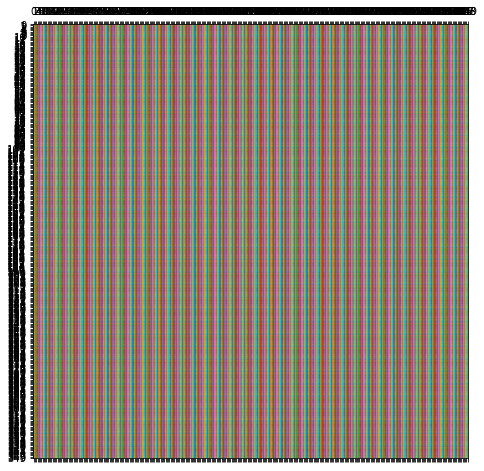

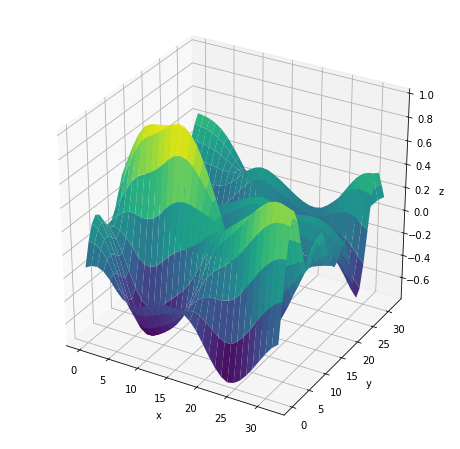

In [17]:
#Displays the whole stm image, as well as lines showing the slice boundaries. Can also show individual slices

#NOTE: assigment for length scale variable is in this code block. Look at image and make a guess
from scipy import interpolate

#Method for separting label array into useful data points
#takes array of 8 labels and returns them in array center_atom and array of arrays neighbors
def split_label(labels):
    center_atom=np.array([labels[0],labels[1]])*32
    neighborvec1=np.array([labels[2],labels[3]])*32
    neighborvec2=np.array([labels[4],labels[5]])*32
    neighborvec3=np.array([labels[6],labels[7]])*32
    neighbors=[]
    neighbors.append(neighborvec1)
    neighbors.append(neighborvec2)
    neighbors.append(neighborvec3)
    return center_atom , neighbors 

#Methods for coloring in the central atom and labels on the images.
#Plots labels given the variables center_atom and neighbors have been assigned
def plot_labels():
    plt.plot(center_atom[0],center_atom[1],'o',color='black')
    plt.plot(neighbors[0][0],neighbors[0][1],'o',color='red')
    plt.plot(neighbors[1][0],neighbors[1][1],'o',color='green')
    plt.plot(neighbors[2][0],neighbors[2][1],'o',color='blue')
#Plots labels given the variables center_atom_t and neighbors_t have been assigned
#These two methods were made to distignuish prediction results from training labels
def plot_test_labels():
    plt.plot(center_atom_t[0],center_atom_t[1],'o',color='xkcd:gray')
    plt.plot(neighbors_t[0][0],neighbors_t[0][1],'o',color='xkcd:dark red')
    plt.plot(neighbors_t[1][0],neighbors_t[1][1],'o',color='xkcd:dark green')
    plt.plot(neighbors_t[2][0],neighbors_t[2][1],'o',color='xkcd:dark blue')
Gaussian= lambda x,scl,amp: amp*math.e**(-0.5*(x/scl)**2)
#3D versions of the label plots. A bit finiky, the labels tend to appeear within the 3d data
def plot_labels_3d():
    height=Gaussian(0,atom_size,corr)
    s=30
    ax.scatter3D(center_atom[0],center_atom[1],height,'o',color='black',s=s)
    ax.scatter3D(neighbors[0][0],neighbors[0][1],height,'o',color='red',s=s)
    ax.scatter3D(neighbors[1][0],neighbors[1][1],height,'o',color='green',s=s)
    ax.scatter3D(neighbors[2][0],neighbors[2][1],height,'o',color='blue',s=s) 
def plot_test_labels_3d():
    height=Gaussian(0,atom_size,corr)
    s=30
    ax.scatter3D(center_atom_t[0],center_atom_t[1],height,'o',color='gray',s=s)
    ax.scatter3D(neighbors_t[0][0],neighbors_t[0][1],height,'o',color='xkcd:dark red',s=s)
    ax.scatter3D(neighbors_t[1][0],neighbors_t[1][1],height,'o',color='xkcd:dark green',s=s)
    ax.scatter3D(neighbors_t[2][0],neighbors_t[2][1],height,'o',color='xkcd:dark blue',s=s)
#Methods for plotting lines over original stm data to indicate where slices have been taken
def plot_horizontal_lines():
    for i in range(stm.shape[0]-step+1)[::step]:
        plt.plot((i,i),(0,stm.shape[1]-1))
def plot_vertical_lines():
    for i in range(stm.shape[1]-step+1)[::step]:
        plt.plot((0,stm.shape[0]-1),(i,i))
def plot_slices():
    plot_vertical_lines()
    plot_horizontal_lines() 

#Method to plot any 2d array as a 3d surface. x and y values are assumed by index
def plot_3d(arr):
    ny,nx = arr.shape
    x = np.linspace(0,nx,nx)
    y = np.linspace(0,ny,ny)
    xv, yv = np.meshgrid(x,y)
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(111,projection='3d')
    height3d=ax.plot_surface(xv,yv,arr,linewidth=0,alpha=1,cmap='viridis')
    ax.set_zlabel('z')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
#Strips an array of points and returns a list of x values and a list of y values. Useful for many plotting methods
def get_xy(arr):
    x=np.take(arr,0,axis=1)
    y=np.take(arr,1,axis=1)
    return x,y

#%matplotlib inline
#%matplotlib notebook
# coords=np.load('Graphene159_64to128_handlabels.npy')
# x,y=get_xy(coords)
# x-=2
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.matshow(stm,cmap='gray')
#ax.axis('off')
# plt.xlim(64,128)
# plt.ylim(128,64)
# ax.plot(x,y,'o',color='black')

#coords = []
# def onclick(event):
#     global ix, iy
#     ix, iy = event.xdata, event.ydata
#     print(f'x = {ix}, y = {iy}')

#     global coords
#     coords.append((ix, iy))


#     return coords
#cid = fig.canvas.mpl_connect('button_press_event', onclick)

plot_slices()
plt.xticks(range(stm.shape[0]-step+1)[::step],range((stm.shape[0])//step))
plt.yticks(range(stm.shape[1]-step+1)[::step],range((stm.shape[1])//step))

## Variable to assign average bond length if it is a parameter in the given model
## Placed here such that relevant plots are available
#len_scale=np.array([10])

#%matplotlib notebook

#plot_3d(stm_slice[3,3])
data=stm_slice_back[3,3]
data -= np.mean(data)
data_max=np.max(data)
data /= data_max
plot_3d(data)

# fig = plt.figure(figsize = (8, 8))
# ax = plt.subplot(1,1,1)
# ax.matshow(stm_slice_back[3,3],cmap='viridis')
# ax.axis('off')


In [18]:
import scipy.ndimage.filters as filters
import scipy.ndimage.morphology as morphology

#methods to 
def detect_local_minima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_min = (filters.minimum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_minima = local_min ^ eroded_background
    #return np.where(detected_minima)  
    return detected_minima


def detect_local_maxima(arr):
    # https://stackoverflow.com/questions/3684484/peak-detection-in-a-2d-array/3689710#3689710
    """
    Takes an array and detects the troughs using the local maximum filter.
    Returns a boolean mask of the troughs (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """
    # define an connected neighborhood
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#generate_binary_structure
    neighborhood = morphology.generate_binary_structure(len(arr.shape),2)
    # apply the local minimum filter; all locations of minimum value 
    # in their neighborhood are set to 1
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.filters.html#minimum_filter
    local_max = (filters.maximum_filter(arr, footprint=neighborhood)==arr)
    # local_min is a mask that contains the peaks we are 
    # looking for, but also the background.
    # In order to isolate the peaks we must remove the background from the mask.
    # 
    # we create the mask of the background
    background = (arr==0)
    # 
    # a little technicality: we must erode the background in order to 
    # successfully subtract it from local_min, otherwise a line will 
    # appear along the background border (artifact of the local minimum filter)
    # http://www.scipy.org/doc/api_docs/SciPy.ndimage.morphology.html#binary_erosion
    eroded_background = morphology.binary_erosion(
        background, structure=neighborhood, border_value=1)
    # 
    # we obtain the final mask, containing only peaks, 
    # by removing the background from the local_min mask
    detected_maxima = local_max ^ eroded_background
    return detected_maxima

1710


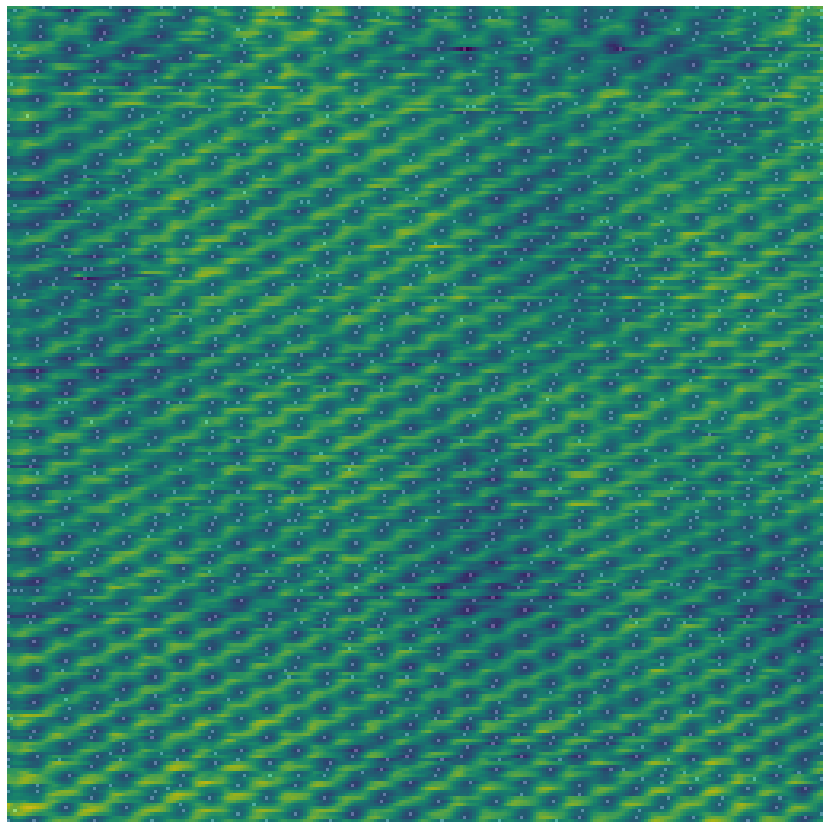

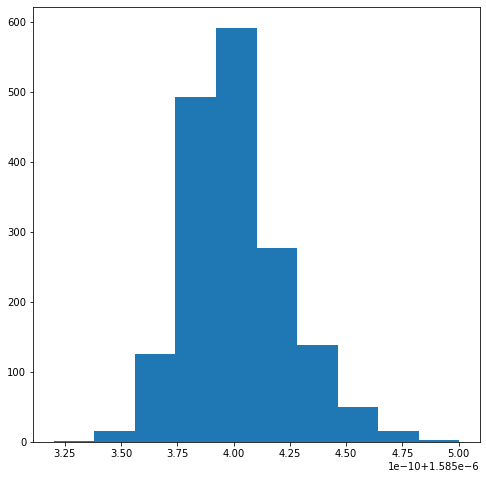

In [59]:
test_arr=np.copy(stm)
mask=detect_local_minima(test_arr)
mask_indicies=np.where(mask)

def get_minima(cutoff=None):
    if cutoff != None:
        cutoff*=1e-10
        cutoff+=1.585e-6
    minima=[]
    for i in range(len(mask_indicies[0])):
        if cutoff==None:
            minima.append(test_arr[mask_indicies[0][i]][mask_indicies[1][i]])
        else:
            if test_arr[mask_indicies[0][i]][mask_indicies[1][i]]<=cutoff:
                minima.append(test_arr[mask_indicies[0][i]][mask_indicies[1][i]])
            else:
                mask[mask_indicies[0][i]][mask_indicies[1][i]]=False
    return minima
    


minima=get_minima()
fig = plt.figure(figsize = (15, 15))
ax = plt.subplot(1,1,1)
ax.matshow(test_arr,cmap='viridis')
ax.matshow(mask,cmap='gray',alpha=0.2)
ax.axis('off')
            
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.hist(minima)
print(len(minima))

In [26]:
#fig.canvas.mpl_disconnect(cid)

# Predicting on Real Data

In [19]:
#Predicts whole image at once. Saves predictions in a 2D array

def data_aug(data): #Performs data aumentation before being fed into batch
#     #Standardization
#     data -= np.mean(data)
#     data /= np.std(data)
    
    #Divide out the max
    data -= np.mean(data)
    data_max=np.max(data)
    data /= data_max
        
    data=np.reshape(data,(32,32,1))
    return data
    
model_name="run9_8"
prediction_arr_dir=os.path.join('Prediction_Plots',model_name +" STM tests arrays")
os.makedirs(prediction_arr_dir)
num_labels=2
# predictions=np.empty((stm_slice_back.shape[1],stm_slice_back.shape[0],num_labels))

# for x in notebook.tqdm(range(stm_slice_back.shape[0])):
#     for y in range(stm_slice_back.shape[1]):
#         prediction_image=stm_slice_back[x,y]
#         batch_stm= data_aug(prediction_image)
#         batch_stm=np.expand_dims(batch_stm, axis=0)
#         prediction=model.predict(batch_stm)
#         prediction=prediction[0]
#         predictions[y][x]=prediction

predictions=np.empty((stm_slice_back.shape[1],stm_slice_back.shape[0],num_labels))

for x in notebook.tqdm(range(stm_slice_back.shape[0])):
    for y in range(stm_slice_back.shape[1]):
        prediction_image=stm_slice_back[x,y]
        batch_stm= data_aug(prediction_image)
        batch_stm=np.expand_dims(batch_stm, axis=0)
        prediction=model.predict(batch_stm)
        prediction=prediction[0]
        predictions[y][x]=prediction

np.save(os.path.join(prediction_arr_dir,"MoC2_886.npy"),predictions)

FileNotFoundError: [Errno 2] No such file or directory: 'Prediction_Plots\\run9_8 STM tests arrays\\MoC2_886.npy'

In [21]:
#Splits saved predictions up into points

model_name="run7_30_centerpoint"
prediction_arr_dir=os.path.join('Prediction_Plots',model_name +" STM tests arrays")
predictions=np.load(os.path.join(prediction_arr_dir,"MoC2_886_test1.npy"))

size=25
step=1

#Takes the prediction array and returns lists of points for each pair of labels. 
def get_split_labels_arr(arr,image_size=32):
    center_atoms=np.empty((arr.shape[0],arr.shape[1],2))
    neighbor1_atoms=np.empty((arr.shape[0],arr.shape[1],2))
    neighbor2_atoms=np.empty((arr.shape[0],arr.shape[1],2))
    neighbor3_atoms=np.empty((arr.shape[0],arr.shape[1],2))
    for x in range(arr.shape[1]):
        for y in range(arr.shape[0]):
            center_atom_temp,neighbors_temp=split_label(arr[x,y])
            center_atom_temp *= size/image_size #Resizes labels to original slice size
            center_atom_temp[0] += step*x #Translates label to proper section of stm image
            center_atom_temp[1] += step*y
            for i in range(3):
                neighbors_temp[i] *= size/image_size
                neighbors_temp[i][0] += step*x
                neighbors_temp[i][1] += step*y
            center_atoms[x,y]=center_atom_temp
            neighbor1_atoms[x,y]=neighbors_temp[0]
            neighbor2_atoms[x,y]=neighbors_temp[1]
            neighbor3_atoms[x,y]=neighbors_temp[2]
    return center_atoms, neighbor1_atoms, neighbor2_atoms, neighbor3_atoms


center_atoms, neighbor1_atoms, neighbor2_atoms, neighbor3_atoms= get_split_labels_arr(predictions,image_size=32)
flat_center_atoms=center_atoms.reshape(-1,center_atoms.shape[-1])
flat_neighbor1_atoms=neighbor1_atoms.reshape(-1,neighbor1_atoms.shape[-1])
flat_neighbor2_atoms=neighbor2_atoms.reshape(-1,neighbor2_atoms.shape[-1])
flat_neighbor3_atoms=neighbor3_atoms.reshape(-1,neighbor3_atoms.shape[-1])


In [22]:
#Splits saved predictions up into points for the 2 labeled centerpoint model

model_name="run9_8"
prediction_arr_dir=os.path.join('Prediction_Plots',model_name +" STM tests arrays")
predictions=np.load(os.path.join(prediction_arr_dir,"MoC2_886.npy"))

size=25
step=1

def split_label_uc(labels,image_size):
    center_atom=np.array([labels[0],labels[1]])*image_size
    return center_atom 


def get_split_labels_arr_uc(arr,image_size=32):
    center_atoms=np.empty((arr.shape[0],arr.shape[1],2))
    for x in range(arr.shape[1]):
        for y in range(arr.shape[0]):
            center_atom_temp=split_label_uc(arr[x,y],image_size)
            center_atom_temp *= size/image_size
            center_atom_temp[0] += step*x
            center_atom_temp[1] += step*y
            center_atoms[x,y]=center_atom_temp
    return center_atoms


center_atoms= get_split_labels_arr_uc(predictions,image_size=32)
flat_center_atoms=center_atoms.reshape(-1,center_atoms.shape[-1])

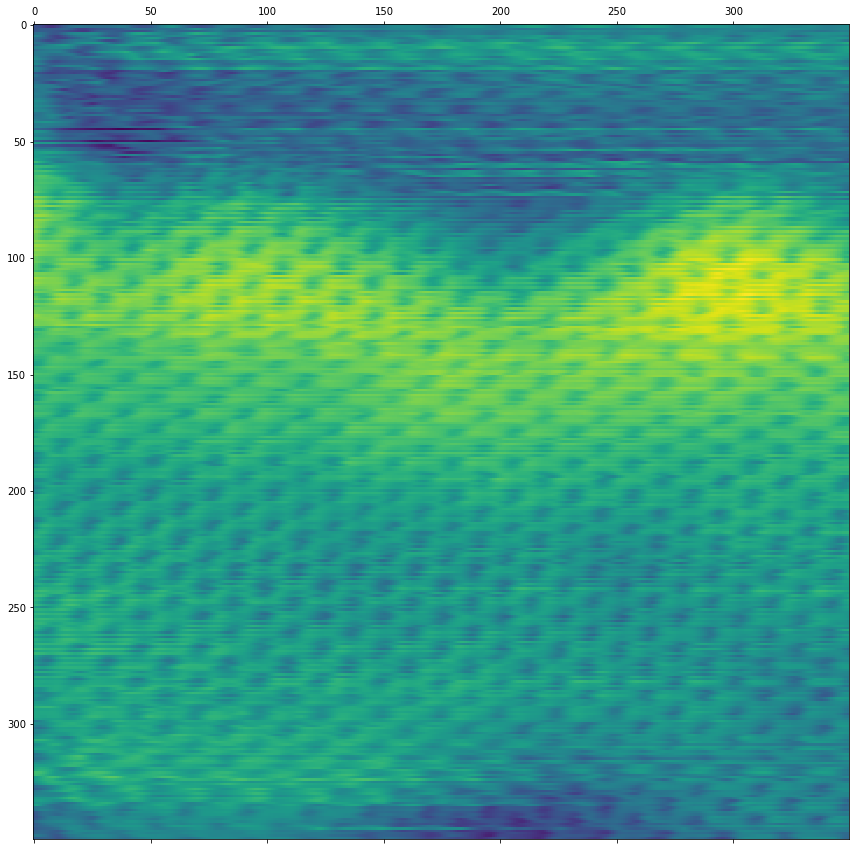

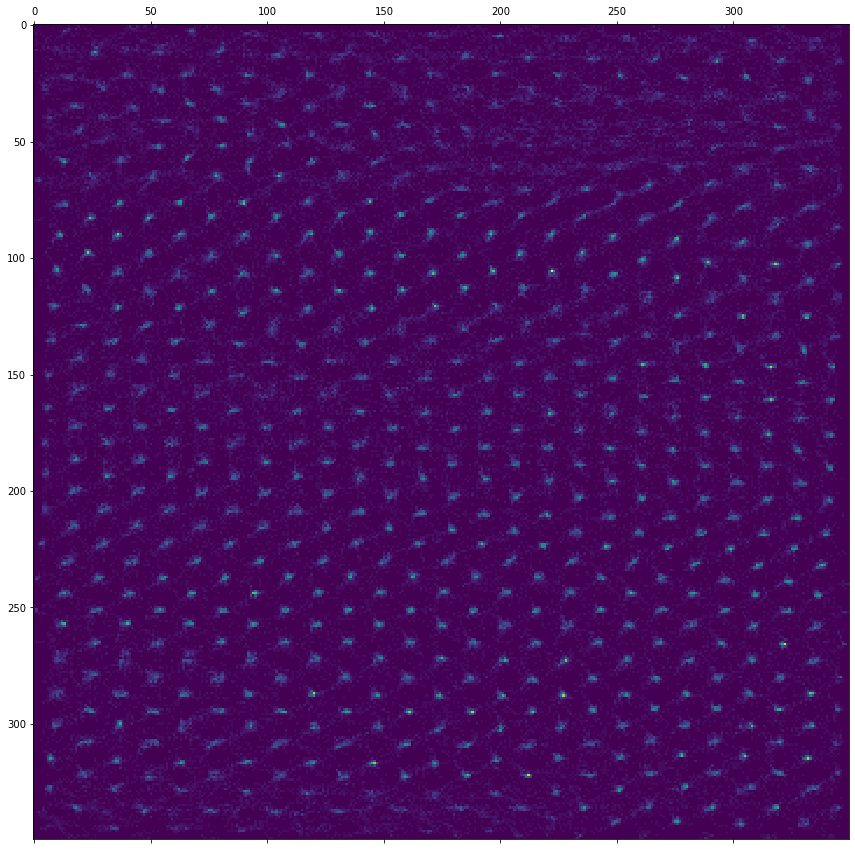

In [32]:
#Cell for grouping datapoints. Itterativley takes averages of nearest neighbors around points with radius r

#Plots the points in an array
def plot_points_arr(arr,color):
    x=np.take(arr,0,axis=1)
    y=np.take(arr,1,axis=1)
    plt.plot(x,y,'o',color=color)

#histogram methods. Either returns the histogram array or plots the histogram
def make_hist_arr(arr,bins):
    x=np.take(arr,0,axis=1)
    y=np.take(arr,1,axis=1)
    H, xedges, yedges= np.histogram2d(x,y,bins=bins)
    return H
def plot_hist_arr(arr,alpha):
    x=np.take(arr,0,axis=1)
    y=np.take(arr,1,axis=1)
    plt.hist2d(x,y,bins=(250,250),cmap='viridis',alpha=alpha)

#Methods that implement the nearest neighbor grouping.
def get_averaged_points(NNlist,atom_list):
    averaged_points=[]
    for n in NNlist:
        averagex=0
        averagey=0
        for p in n:
            averagex+=atom_list[p][0]
            averagey+=atom_list[p][1]
        averagex/=float(len(n))
        averagey/=float(len(n))
        averaged_points.append([averagex,averagey])
    averaged_points=np.array(averaged_points)
    return averaged_points
def group_data(atom_list,r):
    NNTree=cKDTree(atom_list)
    NNlist=NNTree.query_ball_tree(NNTree,r)
    
    average_points=get_averaged_points(NNlist,atom_list)
    return average_points
#Will group a collection of points based on a list of values representing neighbor distances
# Ie r_values=[5,3,5] means return the average location of a point and all the points within 5 pixels of it for every 
#    point in atom_list, then do the same with 3 pixels on that result, then do it with 5 pixels on that result
def recursive_group(atom_list,r_values):
    atom_list=atom_list
    for i in range(len(r_values)):
        atom_list=group_data(atom_list,r_values[i])
    return atom_list

#Strips an array of points and returns a list of x values and a list of y values. Useful for many plotting methods
def get_xy(arr):
    x=np.take(arr,0,axis=1)
    y=np.take(arr,1,axis=1)
    return x,y

#%matplotlib inline
fig = plt.figure(figsize = (15, 15))
ax = plt.subplot(1,1,1)
ax.matshow(stm,cmap='viridis')

#plot_points_arr(flat_center_atoms[::],'black')
#plot_hist_arr(flat_center_atoms,0.5)
#plot_points_arr(vor.vertices,'black')

#plt.xlim(0,256)
#plt.ylim(256,0)

# plot_step=82
# plot_points_arr(flat_center_atoms[::plot_step],'black')
# plot_points_arr(flat_neighbor1_atoms[::plot_step],'red')
# plot_points_arr(flat_neighbor2_atoms[::plot_step],'green')
# plot_points_arr(flat_neighbor3_atoms[::plot_step],'blue')


# averaged_points_c=recursive_group(flat_center_atoms,[6,2])
# x_c,y_c=get_xy(averaged_points_c)
# plt.plot(x_c,y_c,'o',color='black')

hist_arr=make_hist_arr(flat_center_atoms,stm.shape[0])

fig = plt.figure(figsize = (15, 15))
ax = plt.subplot(1,1,1)
ax.matshow(np.transpose(hist_arr),cmap='viridis', alpha=1)
# plot_hist_arr(flat_center_atoms,1)

#plt.savefig(os.path.join(prediction_arr_dir,"Graphene-SiC_160_1step_20size_fftdonut35_26_1_hist"))

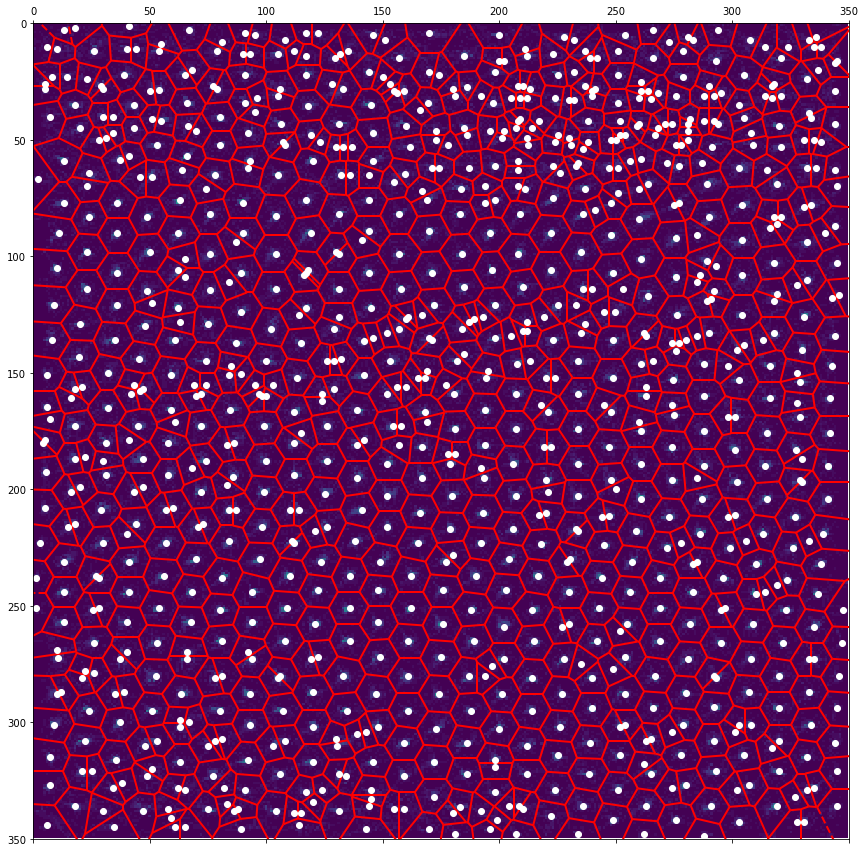

In [36]:
#Cell for making Voronoi diagram.
# Finds all the local maxima in the image, different from above detect_local_maxima method. These maxima are then used
#     to create a voronoi diagram
import scipy.ndimage as ndimage
from scipy.spatial import Voronoi, voronoi_plot_2d
neighborhood_size = 5
threshold = 3 #minimum height for a maxima. Useful for ignoring noise

data =np.transpose(make_hist_arr(flat_center_atoms,stm.shape[0]))

data_max = filters.maximum_filter(data, neighborhood_size)
maxima = (data == data_max)
data_min = filters.minimum_filter(data, neighborhood_size)
diff = ((data_max - data_min) > threshold)
maxima[diff == 0] = 0

labeled, num_objects = ndimage.label(maxima)
slices = ndimage.find_objects(labeled)
x, y = [], []
for dy,dx in slices:
    x_center = (dx.start + dx.stop - 1)/2
    x.append(x_center)
    y_center = (dy.start + dy.stop - 1)/2    
    y.append(y_center)

points=list(zip(x,y))
points=np.array(points)
#points=recursive_group(points,[6])

vor = Voronoi(points)

fig = plt.figure(figsize = (15, 15))
ax = plt.subplot(1,1,1)
#ax.matshow(stm_back,cmap='viridis')
ax.matshow(data,cmap='viridis',alpha=1)
voronoi_plot_2d(vor,ax=ax,show_points=False,show_vertices=False,line_width=2,line_colors='red')
plot_points_arr(points,'white')
plt.xlim(0,350)
plt.ylim(350,0)
plt.show()

# Older Code Snippets

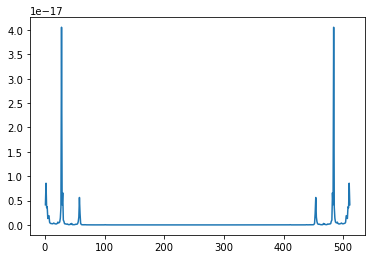

In [17]:
# Code for calulating the beta value from an image. Doesn't really work in our case
DFTs=[]
for i in range(stm.shape[0]):
    DFTs.append(fft(stm[i]))
gamma=np.zeros(stm.shape[0])
for i in range(stm.shape[0]):
    gamma+= np.abs(DFTs[i])**2/stm.shape[0]
#print(gamma)
x=range(0,stm.shape[0])
plt.plot(x[1:],gamma[1:])

In [7]:
#Generator and predictor for real STM image single snippet. 
prediction_image=stm_slice[6,6]

batch_stm=np.reshape(prediction_image,(32,32,1))
batch_stm=np.expand_dims(batch_stm, axis=0)
prediction=model.predict(batch_stm)
prediction=prediction[0]
#assingns relevant datapoints
center_atom,neighbors=split_label(prediction)


#Plots the predictions on the STM image
model_name="run7_03_standardized"
prediction_plots_dir=os.path.join('Prediction_Plots',model_name +" STM tests")

fig = plt.figure(figsize = (10, 10))
ax = plt.subplot(1,1,1)
ax.imshow(prediction_image,cmap='gray')
plot_labels()
#plt.savefig(os.path.join(prediction_plots_dir,))

In [8]:
#ARRAY:Loads in a single testing image and plots its prediction vs true labels
model_name='run7_02_lr_001'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Training_set_6_29'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))




index=151346
im_filename=dft['filename'][index]
atom_size=dft['atom_size'][index]
corr=dft['corr'][index]+.1


test_im=np.load(os.path.join(test_dataset_dir,im_filename))

label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
test_labels=dft[label_names].loc[index].to_numpy()
prediction_labels=dfp[label_names].loc[index].to_numpy()

center_atom_t,neighbors_t=split_label(test_labels)
center_atom,neighbors=split_label(prediction_labels)

#os.makedirs(os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d")))
prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))


%matplotlib inline
im=STMImage(test_im)
fig = plt.figure(figsize = (8, 8))
ax = plt.subplot(1,1,1)
ax.imshow(im.image)
ax.axis('off')
plot_test_labels()
plot_labels()



#plt.savefig(os.path.join(prediction_plots_dir,"small test train_image_"+str(index)+"_"+model_name))

In [3]:
# NOTICE: will only work with the datasets created using for loops, not for the random datasets
bl_list=np.linspace(7,9,num=4)
offx_list=np.linspace(-5,5,num=5)
offy_list=np.linspace(-5,5,num=5)
atom_size_list=np.linspace(2,3.5,num=3)
q_list=np.linspace(0,.1,num=5)
r_list=np.linspace(0,.1,num=5)
b_list=np.linspace(0,.1,num=5)
angle_list=np.linspace(-30,30,num=8)
#Returns the filename of a given image in the dataframe. Inputs are NOT the values of the parameters, they are the indicies, asking for the i'th value of each parameter. ie _bl=3 means the 4th value bl can take in the dataset
def get_filename(_bl,_offx,_offy,_a_s,_q,_r,_b,_angle):
    bl=bl_list[_bl]
    offx=offx_list[_offx]
    offy=offy_list[_offy]
    atom_size=atom_size_list[_a_s]
    q=q_list[_q]
    r=r_list[_r]
    b=b_list[_b]
    angle=angle_list[_angle]
    filename=f"bl{str(bl).replace('.','').replace('-','neg')}_offx{str(offx).replace('.','').replace('-','neg')}_offy{str(offy).replace('.','').replace('-','neg')}_as{str(atom_size).replace('.','')}_strain{str(q).replace('.','')}{str(r).replace('.','')}{str(b).replace('.','')}_angle{str(angle).replace('.','').replace('-','neg')}.png"
    return filename


In [ ]:
#IMAGE:Loads in a single testing image and plots its prediction vs true labels
model_name='run6_25_arrayinput'
test_dataset_dir ='\\Users\\danie\\Penn_State_REU_Jupyter\\Hexagon ML Project GitHub\\Older Code and Training sets\\Training_set_6_25'
prediction_dir=os.path.join("Training_Set_Predictions",model_name)
dft = pd.read_csv(os.path.join(test_dataset_dir,"training_dataframe.csv"))
dfp= pd.read_csv(os.path.join(prediction_dir,"predictions_dataframe.csv"))
#get_filename params are the indicies for (bond length, offx, offy, atom size, q, r, b, anlge)
#im_filename=get_filename(3,0,4,1,0,2,0,3)
#print(im_filename)
#index=np.flatnonzero(dft['filename']==im_filename)[0]
index=27742

test_im=image.load_img(os.path.join(test_dataset_dir,dft['filename'][index]))
test_im_arr=image.img_to_array(test_im)
test_im_arr_batch=np.array([test_im_arr])
label_names=['x_coord','y_coord','neighbor1x','neighbor1y','neighbor2x','neighbor2y','neighbor3x','neighbor3y']
test_labels=dft[label_names].loc[index].to_numpy()
prediction_labels=dfp[label_names].loc[index].to_numpy()

center_atom_t,neighbors_t=split_label(test_labels)
center_atom,neighbors=split_label(prediction_labels)

prediction_plots_dir=os.path.join('Prediction_Plots',datetime.datetime.now().strftime("%m_%d"))

fig = plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(test_im)
plot_labels()
plot_test_labels()
#plt.savefig(os.path.join(prediction_plots_dir,"train_image_"+str(index)+"_"+model_name))

In [47]:
batch=np.reshape(test_im,(32,32,1))
batch=np.expand_dims(batch, axis=0)
prediction=model.predict(batch)
center_atom,neighbors=split_label(prediction[0])

In [82]:
#Loads in real STM images and crops them. Rescales cropped image to 32x32
def crop_STM(arr,xy,size):
    x,y = xy
    return arr[y:y+size,x:x+size]
image_offset=[155,71]
image_size=20
croping_box=(image_offset[0],image_offset[1],image_offset[0]+image_size,image_offset[1]+image_size)
im=image.load_img("MoC2 _ 349.jpg")
im_crop=im.crop(croping_box)
im_resize=im_crop.resize((32,32))
# im_arr=crop_STM(im_arr,image_offset,32)
# im_arr=np.array(Image.fromarray(im_arr).resize((32,32)))
im_arr=image.img_to_array(im_resize).astype('int')
im_arr_batch=np.array([im_arr])
plt.figure(figsize = (5, 5))
ax = plt.subplot(1,1,1)
ax.imshow(im_arr)